In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 

In [2]:
results_train = np.loadtxt('results_train_500.txt')
label_train = np.loadtxt('label_train.txt', skiprows=658)

# Q1

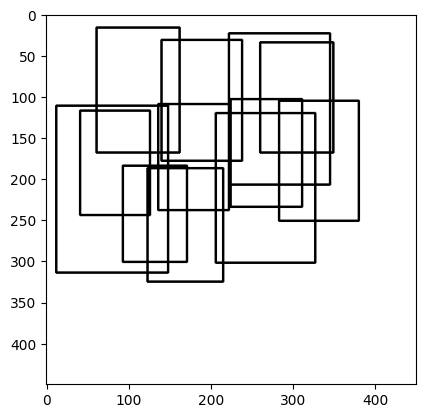

In [3]:
def draw_box(results, index):
    image = np.ones((450,450,3), np.uint8) * 255

    results = results[results[:,0] == index]

    for box in results:
        x1, y1 = int(box[1]), int(box[2])
        w, h = int(box[4]), int(box[3])
        x2, y2 = x1 + w, y1 + h
        
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 0), 2)

    return image

index = 506
image = draw_box(results_train, index)
plt.imshow(image)
plt.show()

# Q2

In [4]:
def rectangle_area(rect):
    return (rect[2] - rect[0]) * (rect[3] - rect[1])

def intersection_area(rect1, rect2):
    x_overlap = max(0, min(rect1[2], rect2[2]) - max(rect1[0], rect2[0]))
    y_overlap = max(0, min(rect1[3], rect2[3]) - max(rect1[1], rect2[1]))
    return x_overlap * y_overlap

def union_area(rect1, rect2):
    area_rect1 = rectangle_area(rect1)
    area_rect2 = rectangle_area(rect2)
    intersection = intersection_area(rect1, rect2)
    return area_rect1 + area_rect2 - intersection

def area_overlap(rect1,rect2):
    return  intersection_area(rect1, rect2)/union_area(rect1, rect2)

def get_rect(i, j, h, l):
    return [i, j, i + h, j + l]

def iou(a, b):
    return area_overlap(get_rect(a[0], a[1], a[2], a[3]), get_rect(b[0], b[1], b[2], b[3]))

# Q3

In [5]:
b1 = [0, 0, 10, 10]
b2 = [0, 0, 10, 10]
print(iou(b1, b2))

b2 = [20, 20, 10, 10]
print(iou(b1, b2))

b2 = [0, 5, 10, 10]
print(iou(b1, b2))

b1 = [21, 4, 140, 10]
b2 = [30, 12, 15, 12]
print(iou(b1, b2))

1.0
0.0
0.3333333333333333
0.01935483870967742


# Q4

In [6]:
def filtre_nms(results_in, tresh_iou = 0.5):
    results_out = np.empty((0,6))
    unique_ids = np.unique(results_in[:,0])
    for i in unique_ids:
        results_in_i = results_in[results_in[:,0] == i]
        results_in_i = results_in_i[ results_in_i[:,5].argsort()[::-1] ]
        results_out_i = np.empty((0,6))
        results_out_i = np.vstack((results_out_i, results_in_i[0]))
        for n in range(1,len(results_in_i)):
            for m in range(len(results_out_i)):
                if iou(results_in_i[n,1:5], results_out_i[m,1:5]) > tresh_iou:
                    break
                elif m == len(results_out_i)-1:
                    results_out_i = np.vstack((results_out_i, results_in_i[n]))
        results_out = np.vstack((results_out,results_out_i))
        
    return results_out

In [7]:
results_train_nms = filtre_nms(results_train, tresh_iou = 0.5)

In [8]:
print(results_train_nms.shape, results_train.shape)

(4842, 6) (4956, 6)


# Q5

In [9]:
def match_predictions_to_labels(predictions, labels, iou_threshold=0.5):
    """
    Compare les prédictions aux vérités terrain et marque les boîtes comme VP ou FP.
    """
    unique_ids = np.unique(predictions[:, 0])
    results = []

    for img_id in unique_ids:
        pred_for_image = predictions[predictions[:, 0] == img_id]
        labels_for_image = labels[labels[:, 0] == img_id]
        
        matched_labels = np.zeros(len(labels_for_image), dtype=bool)

        for pred in pred_for_image:
            pred_box = pred[1:5]
            pred_score = pred[5]
            matched = False

            for idx, label in enumerate(labels_for_image):
                label_box = label[1:5]
                if iou(pred_box, label_box) > iou_threshold:
                    if not matched_labels[idx]:
                        matched = True
                        matched_labels[idx] = True
                        break
            
            if matched:
                results.append([img_id, *pred_box, pred_score, 'VP'])
            else:
                results.append([img_id, *pred_box, pred_score, 'FP'])

    return np.array(results)

In [18]:
results_marked = match_predictions_to_labels(results_train, label_train)
results_marked[:6]

array([['501.0', '222.0', '47.0', '69.0', '46.0', '1.252526', 'FP'],
       ['501.0', '136.0', '224.0', '63.0', '42.0', '1.418966', 'FP'],
       ['501.0', '79.0', '17.0', '68.0', '45.0', '0.14616', 'FP'],
       ['501.0', '156.0', '10.0', '62.0', '41.0', '0.14616', 'FP'],
       ['501.0', '310.0', '36.0', '68.0', '45.0', '1.418966', 'FP'],
       ['501.0', '79.0', '85.0', '195.0', '130.0', '2.525332', 'VP']],
      dtype='<U32')

# Q6

In [11]:
def detect_faces(predictions, labels, iou_threshold=0.5):
    """
    Compare les prédictions aux vérités terrain pour déterminer les visages détectés et non détectés.
    """
    unique_ids = np.unique(predictions[:, 0])
    detection_results = {}

    for img_id in unique_ids:
        pred_for_image = predictions[predictions[:, 0] == img_id]
        labels_for_image = labels[labels[:, 0] == img_id]
        
        detected_faces = []
        undetected_faces = []
        matched_labels = np.zeros(len(labels_for_image), dtype=bool)

        for idx, label in enumerate(labels_for_image):
            label_box = label[1:5]
            detected = False

            for pred in pred_for_image:
                pred_box = pred[1:5]
                if iou(pred_box, label_box) > iou_threshold:
                    detected = True
                    break
            
            if detected:
                detected_faces.append(label)
                matched_labels[idx] = True
            else:
                undetected_faces.append(label)
        
        detection_results[img_id] = {
            "detected_faces": detected_faces,
            "undetected_faces": undetected_faces
        }

    return detection_results


In [12]:
detection_results = detect_faces(results_train_nms, label_train)
detection_results[506]

{'detected_faces': [array([506.,  58., 107., 115.,  85.])],
 'undetected_faces': []}

# Q7

In [13]:
def calculate_metrics(detection_results, results_marked):
    """
    Calcule la précision, le rappel et le score F1 à partir des résultats de détection.
    """
    VP = results_marked[results_marked[:, 6] == 'VP'].shape[0]
    FP = results_marked[results_marked[:, 6] == 'FP'].shape[0]
    FN = 0
    
    for result in detection_results.values():
        undetected_faces = result['undetected_faces']
        FN += len(undetected_faces)

    precision = VP / (VP + FP) if (VP + FP) > 0 else 0
    recall = VP / (VP + FN) if (VP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return precision, recall, f1_score

precision, recall, f1_score = calculate_metrics(detection_results, results_marked)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")


Precision: 0.10815173527037934
Recall: 0.8562300319488818
F1 Score: 0.19204586169831603


# Q8

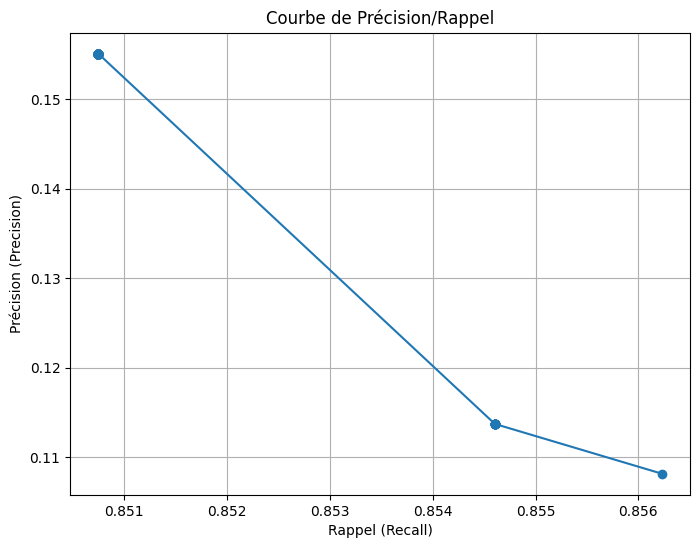

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_metrics_at_thresholds(detection_results, results_marked):
    """
    Calcule la précision, le rappel à différents seuils de score et retourne les valeurs.
    """
    thresholds = np.linspace(0, 1, 101)  # seuils de 0 à 1 avec un pas de 0.01
    precision_list = []
    recall_list = []

    for threshold in thresholds:
        VP = 0
        FP = 0
        FN = 0
        
        filtered_results = results_marked[results_marked[:, 5].astype(float) >= threshold]
        
        VP = filtered_results[filtered_results[:, 6] == 'VP'].shape[0]
        FP = filtered_results[filtered_results[:, 6] == 'FP'].shape[0]
        
        for result in detection_results.values():
            undetected_faces = result['undetected_faces']
            FN += len(undetected_faces)

        precision = VP / (VP + FP) if (VP + FP) > 0 else 0
        recall = VP / (VP + FN) if (VP + FN) > 0 else 0
        
        precision_list.append(precision)
        recall_list.append(recall)

    return precision_list, recall_list

precision_list, recall_list = calculate_metrics_at_thresholds(detection_results, results_marked)

plt.figure(figsize=(8, 6))
plt.plot(recall_list, precision_list, marker='o')
plt.xlabel('Rappel (Recall)')
plt.ylabel('Précision (Precision)')
plt.title('Courbe de Précision/Rappel')
plt.grid(True)
plt.show()


# Q9

In [15]:
from sklearn.metrics import auc

auc_score = auc(recall_list, precision_list)
print(f"Aire sous la courbe: {auc_score}")


Aire sous la courbe: 0.0006988513580163167
